In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

import lightgbm as lgb
from sklearn.model_selection import GroupKFold

# local modules
import sys
sys.path.append("../src")
from preproc import preprocess_data

***
### load and preprocess data

In [2]:
# define some paths
path_raw = Path("../data/raw")
path_processed = Path("../data/processed")
path_results = Path("../data/results")

# load data
df_train = pd.read_csv(path_raw / "train.csv")
df_test = pd.read_csv(path_raw / "test.csv")

df_train

,Id,GameRulesetName,agent1,agent2,Properties,Format,Time,Discrete,Realtime,Turns,...,DoLudeme,Trigger,PlayoutsPerSecond,MovesPerSecond,EnglishRules,LudRules,num_wins_agent1,num_draws_agent1,num_losses_agent1,utility_agent1
0,0,00Y,MCTS-ProgressiveHistory-0.1-MAST-false,MCTS-ProgressiveHistory-0.6-Random200-false,1,1,1,1,0,1,...,0,1,298.07,18877.17,Goal: Connect all three edge colors with a sin...,"(game ""00'Y'"" (players 2) (equipment { (board ...",4,0,11,-0.466667
1,1,00Y,MCTS-ProgressiveHistory-0.1-MAST-false,MCTS-UCB1GRAVE-0.6-NST-true,1,1,1,1,0,1,...,0,1,298.07,18877.17,Goal: Connect all three edge colors with a sin...,"(game ""00'Y'"" (players 2) (equipment { (board ...",5,0,10,-0.333333
2,2,00Y,MCTS-ProgressiveHistory-0.1-MAST-true,MCTS-UCB1-0.1-NST-false,1,1,1,1,0,1,...,0,1,298.07,18877.17,Goal: Connect all three edge colors with a sin...,"(game ""00'Y'"" (players 2) (equipment { (board ...",7,0,8,-0.066667
3,3,00Y,MCTS-ProgressiveHistory-0.1-MAST-true,MCTS-UCB1-0.6-NST-false,1,1,1,1,0,1,...,0,1,298.07,18877.17,Goal: Connect all three edge colors with a sin...,"(game ""00'Y'"" (players 2) (equipment { (board ...",5,0,10,-0.333333
4,4,00Y,MCTS-ProgressiveHistory-0.1-MAST-true,MCTS-UCB1GRAVE-1.41421356237-NST-false,1,1,1,1,0,1,...,0,1,298.07,18877.17,Goal: Connect all three edge colors with a sin...,"(game ""00'Y'"" (players 2) (equipment { (board ...",5,0,10,-0.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
233229,233229,Zuz_Mel_7x7,MCTS-UCB1Tuned-1.41421356237-NST-false,MCTS-ProgressiveHistory-1.41421356237-Random20...,1,1,1,1,0,1,...,0,0,157.52,157174.58,7x7 board. 24 pieces per player. Pieces begin ...,"(game ""Zuz Mel (7x7)"" (players 2) (equipment {...",2,0,13,-0.733333
233230,233230,Zuz_Mel_7x7,MCTS-UCB1Tuned-1.41421356237-Random200-false,MCTS-UCB1-0.6-MAST-false,1,1,1,1,0,1,...,0,0,157.52,157174.58,7x7 board. 24 pieces per player. Pieces begin ...,"(game ""Zuz Mel (7x7)"" (players 2) (equipment {...",9,1,5,0.266667
233231,233231,Zuz_Mel_7x7,MCTS-UCB1Tuned-1.41421356237-Random200-false,MCTS-UCB1GRAVE-1.41421356237-NST-false,1,1,1,1,0,1,...,0,0,157.52,157174.58,7x7 board. 24 pieces per player. Pieces begin ...,"(game ""Zuz Mel (7x7)"" (players 2) (equipment {...",11,3,1,0.666667
233232,233232,Zuz_Mel_7x7,MCTS-UCB1Tuned-1.41421356237-Random200-false,MCTS-UCB1GRAVE-1.41421356237-NST-true,1,1,1,1,0,1,...,0,0,157.52,157174.58,7x7 board. 24 pieces per player. Pieces begin ...,"(game ""Zuz Mel (7x7)"" (players 2) (equipment {...",24,2,4,0.666667


In [3]:
# Call the function
df_train, df_test, numerical_cols, categorical_cols = preprocess_data(
    df_train,
    df_test,
    scale_utility=True
)

# Print the results
print("Numerical Columns:", len(numerical_cols))
print("Categorical Columns:", len(categorical_cols))

Numerical Columns: 588
Categorical Columns: 10


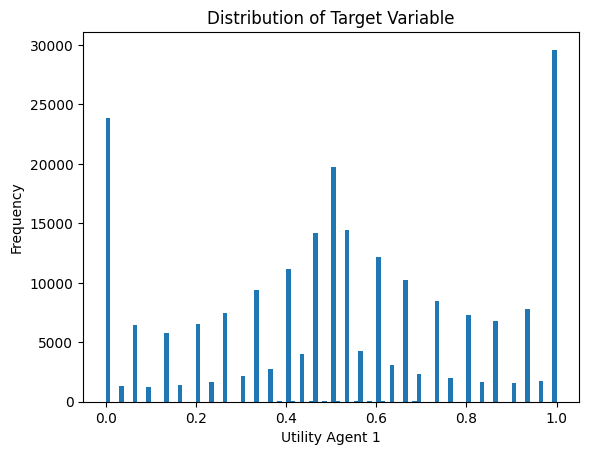

In [4]:
plt.hist(df_train['utility_agent1_scaled'], bins=100)
plt.title('Distribution of Target Variable')
plt.xlabel('Utility Agent 1')
plt.ylabel('Frequency')
plt.show()



***
### train model


In [5]:
# Define the number of folds for cross-validation
num_folds = 5

# Define the column for stratified or group k-fold
groups_col = 'GameRulesetName'
gkf = GroupKFold(n_splits=num_folds)
split_list = gkf.split(df_train, groups=df_train[groups_col])

target = 'utility_agent1'
#target = 'utility_agent1_scaled'

# Define the parameters
params = {
    'objective': "regression" if target == 'utility_agent1' else "cross_entropy",
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'verbose': -1  # Set lower verbosity
}

trained_models = []
oof = pd.DataFrame(index=df_train.index, columns=['utility_agent1_true', 'utility_agent1_pred'])
oof_scores = []

# Perform cross-validation
for fold, (train_index, val_index) in enumerate(split_list, 1):
    print(f"Fold {fold}")
    
    # Split the data
    X_train, X_val = df_train.iloc[train_index], df_train.iloc[val_index]
    y_train, y_val = X_train[target], X_val[target]
    
    # Create LightGBM datasets
    train_data = lgb.Dataset(
        data=X_train[numerical_cols + categorical_cols],
        label=y_train,
        categorical_feature=categorical_cols,
        free_raw_data=True
    )
    val_data = lgb.Dataset(
        data=X_val[numerical_cols + categorical_cols],
        label=y_val,
        categorical_feature=categorical_cols,
        free_raw_data=True
    )

    # Train the model
    model = lgb.train(
        params,
        train_data,
        num_boost_round=2000,
        valid_sets=[val_data],
        callbacks=[lgb.log_evaluation(period=25)]
    )
    
    # Save the trained model to the list
    trained_models.append(model)

    # predict on validation set
    y_pred = model.predict(X_val[numerical_cols + categorical_cols])

    
    if target == "utility_agent1_scaled":
        # scale back predictions and true values to -1 to 1 range
        y_pred = y_pred * 2 - 1
        y_val = y_val * 2 - 1
    else:
        y_pred = np.clip(y_pred, -1, 1)
    
    # Compute RMSE on scaled values
    rmse = np.sqrt(np.mean((y_pred - y_val) ** 2))
    print(f"Fold {fold} - RMSE: {rmse}")

    # Save out-of-fold predictions
    oof.loc[val_index, 'utility_agent1_true'] = y_val
    oof.loc[val_index, 'utility_agent1_pred'] = y_pred

    # Save RMSE to the list
    oof_scores.append(rmse)

# Print the list of oof scores and average oof score
print("List of oof scores:", oof_scores)
print("Average oof score:", np.mean(oof_scores))

# save oof predictions
oof.to_csv(path_results / 'oof_lightgbm.csv', index=False)

Fold 1


[25]	valid_0's rmse: 0.525061


[50]	valid_0's rmse: 0.500715


[75]	valid_0's rmse: 0.489017


[100]	valid_0's rmse: 0.482964


[125]	valid_0's rmse: 0.478693


[150]	valid_0's rmse: 0.47518


[175]	valid_0's rmse: 0.472378


[200]	valid_0's rmse: 0.469716


[225]	valid_0's rmse: 0.467938


[250]	valid_0's rmse: 0.466202


[275]	valid_0's rmse: 0.465194


[300]	valid_0's rmse: 0.463991


[325]	valid_0's rmse: 0.462833


[350]	valid_0's rmse: 0.461969


[375]	valid_0's rmse: 0.460871


[400]	valid_0's rmse: 0.45982


[425]	valid_0's rmse: 0.458895


[450]	valid_0's rmse: 0.458085


[475]	valid_0's rmse: 0.457593


[500]	valid_0's rmse: 0.456511


[525]	valid_0's rmse: 0.455862


[550]	valid_0's rmse: 0.455138


[575]	valid_0's rmse: 0.454346


[600]	valid_0's rmse: 0.454043


[625]	valid_0's rmse: 0.453481


[650]	valid_0's rmse: 0.453182


[675]	valid_0's rmse: 0.452763


[700]	valid_0's rmse: 0.452619


[725]	valid_0's rmse: 0.452041


[750]	valid_0's rmse: 0.451629


[775]	valid_0's rmse: 0.451142


[800]	valid_0's rmse: 0.450705


[825]	valid_0's rmse: 0.450448


[850]	valid_0's rmse: 0.450112


[875]	valid_0's rmse: 0.449788


[900]	valid_0's rmse: 0.449439


[925]	valid_0's rmse: 0.449208


[950]	valid_0's rmse: 0.448919


[975]	valid_0's rmse: 0.448585


[1000]	valid_0's rmse: 0.448628


[1025]	valid_0's rmse: 0.448439


[1050]	valid_0's rmse: 0.448362


[1075]	valid_0's rmse: 0.448175


[1100]	valid_0's rmse: 0.447924


[1125]	valid_0's rmse: 0.447788


[1150]	valid_0's rmse: 0.447488


[1175]	valid_0's rmse: 0.447446


[1200]	valid_0's rmse: 0.447327


[1225]	valid_0's rmse: 0.447262


[1250]	valid_0's rmse: 0.447246


[1275]	valid_0's rmse: 0.447292


[1300]	valid_0's rmse: 0.4472


[1325]	valid_0's rmse: 0.447078


[1350]	valid_0's rmse: 0.447068


[1375]	valid_0's rmse: 0.447022


[1400]	valid_0's rmse: 0.44689


[1425]	valid_0's rmse: 0.446808


[1450]	valid_0's rmse: 0.446741


[1475]	valid_0's rmse: 0.446638


[1500]	valid_0's rmse: 0.446557


[1525]	valid_0's rmse: 0.446492


[1550]	valid_0's rmse: 0.446412


[1575]	valid_0's rmse: 0.446352


[1600]	valid_0's rmse: 0.446279


[1625]	valid_0's rmse: 0.446213


[1650]	valid_0's rmse: 0.446185


[1675]	valid_0's rmse: 0.446193


[1700]	valid_0's rmse: 0.446003


[1725]	valid_0's rmse: 0.445817


[1750]	valid_0's rmse: 0.445762


[1775]	valid_0's rmse: 0.445705


[1800]	valid_0's rmse: 0.445663


[1825]	valid_0's rmse: 0.44562


[1850]	valid_0's rmse: 0.445617


[1875]	valid_0's rmse: 0.44556


[1900]	valid_0's rmse: 0.445447


[1925]	valid_0's rmse: 0.445295


[1950]	valid_0's rmse: 0.445205


[1975]	valid_0's rmse: 0.445156


[2000]	valid_0's rmse: 0.445087


Fold 1 - RMSE: 0.44424557887887145
Fold 2


[25]	valid_0's rmse: 0.525248


[50]	valid_0's rmse: 0.499132


[75]	valid_0's rmse: 0.488319


[100]	valid_0's rmse: 0.483947


[125]	valid_0's rmse: 0.479654


[150]	valid_0's rmse: 0.476463


[175]	valid_0's rmse: 0.474474


[200]	valid_0's rmse: 0.47353


[225]	valid_0's rmse: 0.471949


[250]	valid_0's rmse: 0.472134


[275]	valid_0's rmse: 0.471061


[300]	valid_0's rmse: 0.469313


[325]	valid_0's rmse: 0.468442


[350]	valid_0's rmse: 0.467292


[375]	valid_0's rmse: 0.466686


[400]	valid_0's rmse: 0.466047


[425]	valid_0's rmse: 0.465557


[450]	valid_0's rmse: 0.464937


[475]	valid_0's rmse: 0.464502


[500]	valid_0's rmse: 0.46387


[525]	valid_0's rmse: 0.463303


[550]	valid_0's rmse: 0.46284


[575]	valid_0's rmse: 0.462498


[600]	valid_0's rmse: 0.461854


[625]	valid_0's rmse: 0.461398


[650]	valid_0's rmse: 0.461133


[675]	valid_0's rmse: 0.460769


[700]	valid_0's rmse: 0.460601


[725]	valid_0's rmse: 0.460335


[750]	valid_0's rmse: 0.460149


[775]	valid_0's rmse: 0.459842


[800]	valid_0's rmse: 0.459642


[825]	valid_0's rmse: 0.459275


[850]	valid_0's rmse: 0.459103


[875]	valid_0's rmse: 0.458917


[900]	valid_0's rmse: 0.458774


[925]	valid_0's rmse: 0.458406


[950]	valid_0's rmse: 0.458202


[975]	valid_0's rmse: 0.458149


[1000]	valid_0's rmse: 0.458063


[1025]	valid_0's rmse: 0.457756


[1050]	valid_0's rmse: 0.457603


[1075]	valid_0's rmse: 0.457376


[1100]	valid_0's rmse: 0.457251


[1125]	valid_0's rmse: 0.457249


[1150]	valid_0's rmse: 0.457043


[1175]	valid_0's rmse: 0.45694


[1200]	valid_0's rmse: 0.456833


[1225]	valid_0's rmse: 0.456645


[1250]	valid_0's rmse: 0.456653


[1275]	valid_0's rmse: 0.456375


[1300]	valid_0's rmse: 0.456208


[1325]	valid_0's rmse: 0.456078


[1350]	valid_0's rmse: 0.455899


[1375]	valid_0's rmse: 0.455746


[1400]	valid_0's rmse: 0.455682


[1425]	valid_0's rmse: 0.455501


[1450]	valid_0's rmse: 0.455381


[1475]	valid_0's rmse: 0.455307


[1500]	valid_0's rmse: 0.455181


[1525]	valid_0's rmse: 0.455142


[1550]	valid_0's rmse: 0.455125


[1575]	valid_0's rmse: 0.455125


[1600]	valid_0's rmse: 0.455035


[1625]	valid_0's rmse: 0.455092


[1650]	valid_0's rmse: 0.455068


[1675]	valid_0's rmse: 0.454994


[1700]	valid_0's rmse: 0.454919


[1725]	valid_0's rmse: 0.454869


[1750]	valid_0's rmse: 0.45487


[1775]	valid_0's rmse: 0.454876


[1800]	valid_0's rmse: 0.454869


[1825]	valid_0's rmse: 0.454803


[1850]	valid_0's rmse: 0.454785


[1875]	valid_0's rmse: 0.454697


[1900]	valid_0's rmse: 0.454676


[1925]	valid_0's rmse: 0.454681


[1950]	valid_0's rmse: 0.454724


[1975]	valid_0's rmse: 0.454631


[2000]	valid_0's rmse: 0.454723


Fold 2 - RMSE: 0.4543047052423459
Fold 3


[25]	valid_0's rmse: 0.526355


[50]	valid_0's rmse: 0.506804


[75]	valid_0's rmse: 0.493297


[100]	valid_0's rmse: 0.484801


[125]	valid_0's rmse: 0.48058


[150]	valid_0's rmse: 0.477119


[175]	valid_0's rmse: 0.475057


[200]	valid_0's rmse: 0.472028


[225]	valid_0's rmse: 0.469958


[250]	valid_0's rmse: 0.468821


[275]	valid_0's rmse: 0.467182


[300]	valid_0's rmse: 0.465817


[325]	valid_0's rmse: 0.464745


[350]	valid_0's rmse: 0.464125


[375]	valid_0's rmse: 0.462769


[400]	valid_0's rmse: 0.46225


[425]	valid_0's rmse: 0.461609


[450]	valid_0's rmse: 0.460839


[475]	valid_0's rmse: 0.460198


[500]	valid_0's rmse: 0.459578


[525]	valid_0's rmse: 0.459336


[550]	valid_0's rmse: 0.458836


[575]	valid_0's rmse: 0.458558


[600]	valid_0's rmse: 0.458175


[625]	valid_0's rmse: 0.457566


[650]	valid_0's rmse: 0.457246


[675]	valid_0's rmse: 0.456821


[700]	valid_0's rmse: 0.456475


[725]	valid_0's rmse: 0.456343


[750]	valid_0's rmse: 0.455968


[775]	valid_0's rmse: 0.455669


[800]	valid_0's rmse: 0.455419


[825]	valid_0's rmse: 0.455224


[850]	valid_0's rmse: 0.455041


[875]	valid_0's rmse: 0.454863


[900]	valid_0's rmse: 0.454469


[925]	valid_0's rmse: 0.454132


[950]	valid_0's rmse: 0.453611


[975]	valid_0's rmse: 0.453391


[1000]	valid_0's rmse: 0.453235


[1025]	valid_0's rmse: 0.453041


[1050]	valid_0's rmse: 0.452899


[1075]	valid_0's rmse: 0.452729


[1100]	valid_0's rmse: 0.452609


[1125]	valid_0's rmse: 0.452541


[1150]	valid_0's rmse: 0.452365


[1175]	valid_0's rmse: 0.452238


[1200]	valid_0's rmse: 0.452024


[1225]	valid_0's rmse: 0.451856


[1250]	valid_0's rmse: 0.451723


[1275]	valid_0's rmse: 0.451659


[1300]	valid_0's rmse: 0.451421


[1325]	valid_0's rmse: 0.451322


[1350]	valid_0's rmse: 0.45123


[1375]	valid_0's rmse: 0.451188


[1400]	valid_0's rmse: 0.451082


[1425]	valid_0's rmse: 0.450822


[1450]	valid_0's rmse: 0.450747


[1475]	valid_0's rmse: 0.45065


[1500]	valid_0's rmse: 0.450572


[1525]	valid_0's rmse: 0.450405


[1550]	valid_0's rmse: 0.450365


[1575]	valid_0's rmse: 0.450233


[1600]	valid_0's rmse: 0.450041


[1625]	valid_0's rmse: 0.449926


[1650]	valid_0's rmse: 0.449801


[1675]	valid_0's rmse: 0.449743


[1700]	valid_0's rmse: 0.449631


[1725]	valid_0's rmse: 0.449554


[1750]	valid_0's rmse: 0.449451


[1775]	valid_0's rmse: 0.449413


[1800]	valid_0's rmse: 0.449414


[1825]	valid_0's rmse: 0.449328


[1850]	valid_0's rmse: 0.449318


[1875]	valid_0's rmse: 0.449241


[1900]	valid_0's rmse: 0.449269


[1925]	valid_0's rmse: 0.449224


[1950]	valid_0's rmse: 0.449197


[1975]	valid_0's rmse: 0.449141


[2000]	valid_0's rmse: 0.449124


Fold 3 - RMSE: 0.4484939815610887
Fold 4


[25]	valid_0's rmse: 0.511246


[50]	valid_0's rmse: 0.488486


[75]	valid_0's rmse: 0.477848


[100]	valid_0's rmse: 0.471166


[125]	valid_0's rmse: 0.466645


[150]	valid_0's rmse: 0.462874


[175]	valid_0's rmse: 0.460025


[200]	valid_0's rmse: 0.457739


[225]	valid_0's rmse: 0.454919


[250]	valid_0's rmse: 0.452327


[275]	valid_0's rmse: 0.451001


[300]	valid_0's rmse: 0.449647


[325]	valid_0's rmse: 0.448785


[350]	valid_0's rmse: 0.447727


[375]	valid_0's rmse: 0.446844


[400]	valid_0's rmse: 0.445751


[425]	valid_0's rmse: 0.444607


[450]	valid_0's rmse: 0.443434


[475]	valid_0's rmse: 0.442756


[500]	valid_0's rmse: 0.442214


[525]	valid_0's rmse: 0.441551


[550]	valid_0's rmse: 0.44119


[575]	valid_0's rmse: 0.440844


[600]	valid_0's rmse: 0.440477


[625]	valid_0's rmse: 0.440241


[650]	valid_0's rmse: 0.439871


[675]	valid_0's rmse: 0.439608


[700]	valid_0's rmse: 0.439127


[725]	valid_0's rmse: 0.43879


[750]	valid_0's rmse: 0.438606


[775]	valid_0's rmse: 0.438332


[800]	valid_0's rmse: 0.437969


[825]	valid_0's rmse: 0.437695


[850]	valid_0's rmse: 0.437426


[875]	valid_0's rmse: 0.437169


[900]	valid_0's rmse: 0.436749


[925]	valid_0's rmse: 0.436279


[950]	valid_0's rmse: 0.435997


[975]	valid_0's rmse: 0.435461


[1000]	valid_0's rmse: 0.434966


[1025]	valid_0's rmse: 0.434746


[1050]	valid_0's rmse: 0.434593


[1075]	valid_0's rmse: 0.434232


[1100]	valid_0's rmse: 0.434055


[1125]	valid_0's rmse: 0.433855


[1150]	valid_0's rmse: 0.433709


[1175]	valid_0's rmse: 0.433626


[1200]	valid_0's rmse: 0.433471


[1225]	valid_0's rmse: 0.433351


[1250]	valid_0's rmse: 0.433127


[1275]	valid_0's rmse: 0.432891


[1300]	valid_0's rmse: 0.432741


[1325]	valid_0's rmse: 0.432691


[1350]	valid_0's rmse: 0.432543


[1375]	valid_0's rmse: 0.432505


[1400]	valid_0's rmse: 0.432374


[1425]	valid_0's rmse: 0.432113


[1450]	valid_0's rmse: 0.432066


[1475]	valid_0's rmse: 0.431956


[1500]	valid_0's rmse: 0.431861


[1525]	valid_0's rmse: 0.431681


[1550]	valid_0's rmse: 0.431605


[1575]	valid_0's rmse: 0.431505


[1600]	valid_0's rmse: 0.431407


[1625]	valid_0's rmse: 0.43128


[1650]	valid_0's rmse: 0.431236


[1675]	valid_0's rmse: 0.431138


[1700]	valid_0's rmse: 0.431038


[1725]	valid_0's rmse: 0.430893


[1750]	valid_0's rmse: 0.430812


[1775]	valid_0's rmse: 0.430695


[1800]	valid_0's rmse: 0.430605


[1825]	valid_0's rmse: 0.430558


[1850]	valid_0's rmse: 0.430544


[1875]	valid_0's rmse: 0.430498


[1900]	valid_0's rmse: 0.430506


[1925]	valid_0's rmse: 0.430507


[1950]	valid_0's rmse: 0.430486


[1975]	valid_0's rmse: 0.430428


[2000]	valid_0's rmse: 0.430385


Fold 4 - RMSE: 0.42984004545625065
Fold 5


[25]	valid_0's rmse: 0.513752


[50]	valid_0's rmse: 0.48933


[75]	valid_0's rmse: 0.478265


[100]	valid_0's rmse: 0.469846


[125]	valid_0's rmse: 0.464516


[150]	valid_0's rmse: 0.459891


[175]	valid_0's rmse: 0.457697


[200]	valid_0's rmse: 0.45628


[225]	valid_0's rmse: 0.454817


[250]	valid_0's rmse: 0.453101


[275]	valid_0's rmse: 0.451705


[300]	valid_0's rmse: 0.450594


[325]	valid_0's rmse: 0.448944


[350]	valid_0's rmse: 0.447893


[375]	valid_0's rmse: 0.446939


[400]	valid_0's rmse: 0.445851


[425]	valid_0's rmse: 0.445071


[450]	valid_0's rmse: 0.444676


[475]	valid_0's rmse: 0.44407


[500]	valid_0's rmse: 0.443795


[525]	valid_0's rmse: 0.443299


[550]	valid_0's rmse: 0.442751


[575]	valid_0's rmse: 0.442583


[600]	valid_0's rmse: 0.441778


[625]	valid_0's rmse: 0.441312


[650]	valid_0's rmse: 0.441286


[675]	valid_0's rmse: 0.44102


[700]	valid_0's rmse: 0.440681


[725]	valid_0's rmse: 0.440479


[750]	valid_0's rmse: 0.440163


[775]	valid_0's rmse: 0.43983


[800]	valid_0's rmse: 0.439713


[825]	valid_0's rmse: 0.439524


[850]	valid_0's rmse: 0.439345


[875]	valid_0's rmse: 0.439119


[900]	valid_0's rmse: 0.439005


[925]	valid_0's rmse: 0.438956


[950]	valid_0's rmse: 0.438645


[975]	valid_0's rmse: 0.438352


[1000]	valid_0's rmse: 0.438151


[1025]	valid_0's rmse: 0.438167


[1050]	valid_0's rmse: 0.437829


[1075]	valid_0's rmse: 0.437674


[1100]	valid_0's rmse: 0.437563


[1125]	valid_0's rmse: 0.437313


[1150]	valid_0's rmse: 0.437182


[1175]	valid_0's rmse: 0.437042


[1200]	valid_0's rmse: 0.43707


[1225]	valid_0's rmse: 0.436894


[1250]	valid_0's rmse: 0.436738


[1275]	valid_0's rmse: 0.43656


[1300]	valid_0's rmse: 0.436286


[1325]	valid_0's rmse: 0.436115


[1350]	valid_0's rmse: 0.435898


[1375]	valid_0's rmse: 0.435771


[1400]	valid_0's rmse: 0.435654


[1425]	valid_0's rmse: 0.435357


[1450]	valid_0's rmse: 0.435232


[1475]	valid_0's rmse: 0.435005


[1500]	valid_0's rmse: 0.434929


[1525]	valid_0's rmse: 0.434844


[1550]	valid_0's rmse: 0.43481


[1575]	valid_0's rmse: 0.434774


[1600]	valid_0's rmse: 0.434712


[1625]	valid_0's rmse: 0.434632


[1650]	valid_0's rmse: 0.434642


[1675]	valid_0's rmse: 0.434567


[1700]	valid_0's rmse: 0.434414


[1725]	valid_0's rmse: 0.434403


[1750]	valid_0's rmse: 0.434369


[1775]	valid_0's rmse: 0.43434


[1800]	valid_0's rmse: 0.434258


[1825]	valid_0's rmse: 0.434267


[1850]	valid_0's rmse: 0.434234


[1875]	valid_0's rmse: 0.434201


[1900]	valid_0's rmse: 0.434184


[1925]	valid_0's rmse: 0.43417


[1950]	valid_0's rmse: 0.434001


[1975]	valid_0's rmse: 0.433942


[2000]	valid_0's rmse: 0.433679


Fold 5 - RMSE: 0.4332308685790049
List of oof scores: [0.44424557887887145, 0.4543047052423459, 0.4484939815610887, 0.42984004545625065, 0.4332308685790049]
Average oof score: 0.4420230359435123


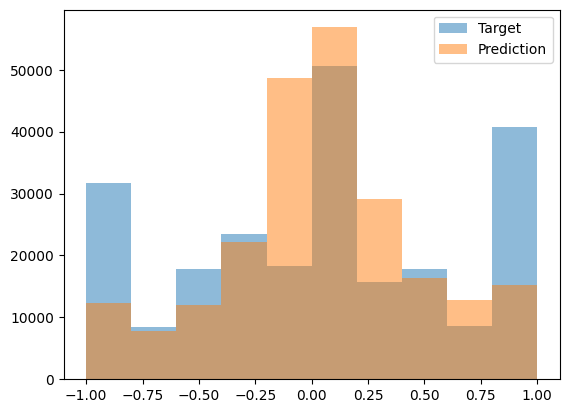

In [6]:
plt.hist(oof['utility_agent1_true'], alpha=0.5, label='Target')
plt.hist(oof['utility_agent1_pred'], alpha=0.5, label='Prediction')
plt.legend()
plt.show()

In [7]:
# Predict on the test set using all trained models
test_predictions = [
    model.predict(df_test[numerical_cols + categorical_cols]) 
    for model in trained_models
]

# Average predictions from all models
final_predictions = np.mean(test_predictions[0], axis=0)

# Create a DataFrame with the predictions
results_df = pd.DataFrame({
    'Id': df_test['Id'],
    'utility_agent1': final_predictions
})

# Save the results to a CSV file
# results_df.to_csv('lightgbm_predictions.csv', index=False)
# print("Predictions saved to 'lightgbm_predictions.csv'")

***